# Customer Churn Prediction

In this project, I will predict customer retention for Interconnect, a telecommunications company, to identify clients likely to cancel their services before they actually leave. Using comprehensive customer data including personal information, contract details, internet services, and phone services, I will use a machine learning model that analyzes customer behavior patterns to predict churn risk with a target accuracy score of 0.88 or higher. This system enables Interconnect's marketing team to proactively offer promotional codes and special plans to at-risk customers, reducing customer loss and improving business profitability.


## Initalization and Preparation¶

In [1]:
import os
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMClassifier
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
print('Missing Customer IDs')
print('Contract:', contract['customerID'].isna().sum())
print('Personal:', personal['customerID'].isna().sum())
print('Internet:', internet['customerID'].isna().sum())
print('Phone:', phone['customerID'].isna().sum())

Missing Customer IDs
Contract: 0
Personal: 0
Internet: 0
Phone: 0


In [4]:
df = personal.merge(contract, left_on=['customerID'], right_on=['customerID'], how='left')
df = df.merge(phone, left_on=['customerID'], right_on=['customerID'], how='left')
df = df.merge(internet, left_on=['customerID'], right_on=['customerID'], how='left')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


In [6]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
df['EndDate'] = df['EndDate'].replace('No', pd.NaT)
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')
df['TotalCharges'] = df['TotalCharges'].replace(' ', 0)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges']).fillna(0)

## Data Analysis¶¶

In [7]:
df['Churn'] = df['EndDate'].notna().astype(int)

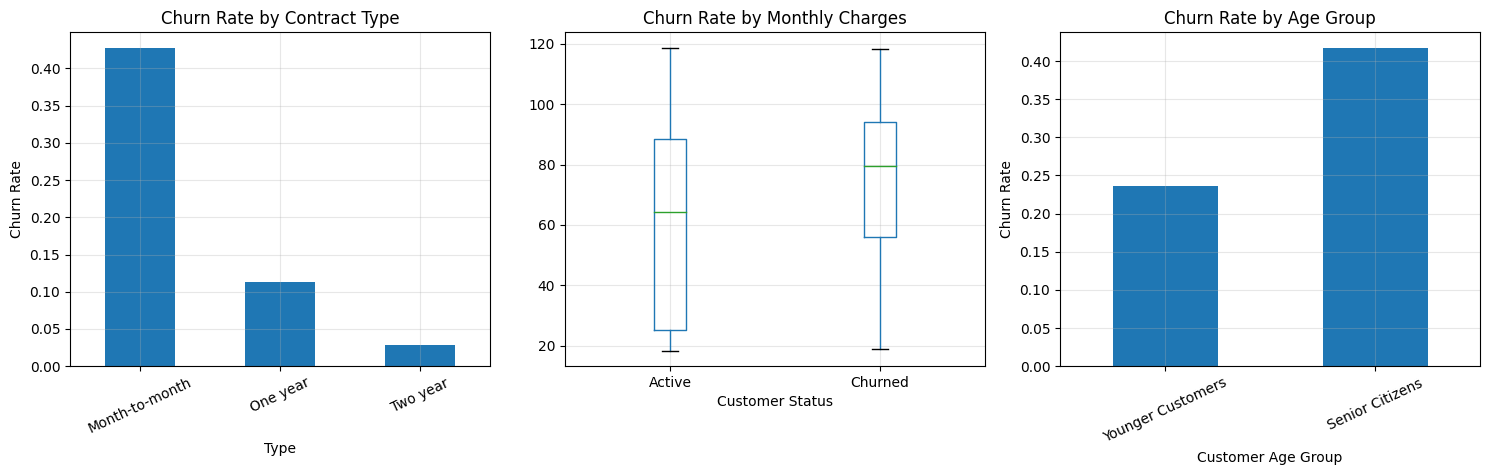

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

churn_by_contract = df.groupby('Type')['Churn'].mean()
churn_by_contract.plot(kind='bar', ax=axes[0])
axes[0].set_title('Churn Rate by Contract Type')
axes[0].set_ylabel('Churn Rate')
axes[0].tick_params(axis='x', rotation=25)
axes[0].grid(True, alpha=0.3)

df.boxplot(column='MonthlyCharges', by='Churn', ax=axes[1])
axes[1].set_title('Churn Rate by Monthly Charges')
axes[1].set_xlabel('Customer Status')
axes[1].set_xticklabels(['Active', 'Churned'])
axes[1].grid(True, alpha=0.3)
plt.suptitle('')

churn_by_senior = df.groupby('SeniorCitizen')['Churn'].mean()
churn_by_senior.plot(kind='bar', ax=axes[2])
axes[2].set_title('Churn Rate by Age Group')
axes[2].set_xlabel('Customer Age Group')
axes[2].set_xticklabels(['Younger Customers', 'Senior Citizens'])
axes[2].tick_params(axis='x', rotation=25)
axes[2].set_ylabel('Churn Rate')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In my exploratory data analysis, I defined customer churn as those who have an end date recorded in their contract information. I then conducted a visual analysis of churn patterns across key customer segments, examining how churn rates vary by contract type, monthly charges, and age demographics. Through these visualizations, I was able to identify initial patterns in customer behavior that suggest contract types and customer characteristics that could lead to churn.


## Creating the Model

In [9]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    eval_stats = {}
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), 
                                   ('test', test_features, test_target)):
        
        eval_stats[type] = {}
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, 
                f1_scores, 
                color=color, label=
                f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')

        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], 
                    f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')

        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], 
                    color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], 
                    color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)

In [10]:
col = ['BeginDate', 'EndDate', 'customerID']
category = ['gender', 'Partner', 'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod', 
            'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df = df.drop(col, axis=1)
df = pd.get_dummies(df, columns=category, drop_first=True)
train, test = train_test_split(df, shuffle=False, test_size=0.2)

features_train = train.drop(['Churn'], axis=1)
target_train = train['Churn']
features_test = test.drop(['Churn'], axis=1)
target_test = test['Churn']

In [11]:
print("Amount who churned:", df[df['Churn'] == 1]['Churn'].count())
print("Amount who didn't churn:", df[df['Churn'] == 0]['Churn'].count())

Amount who churned: 1869
Amount who didn't churn: 5174


Logistic Regression with Class Balance
          train  test
Accuracy   0.75  0.75
F1         0.63  0.61
APS        0.63  0.66
ROC AUC    0.84  0.83


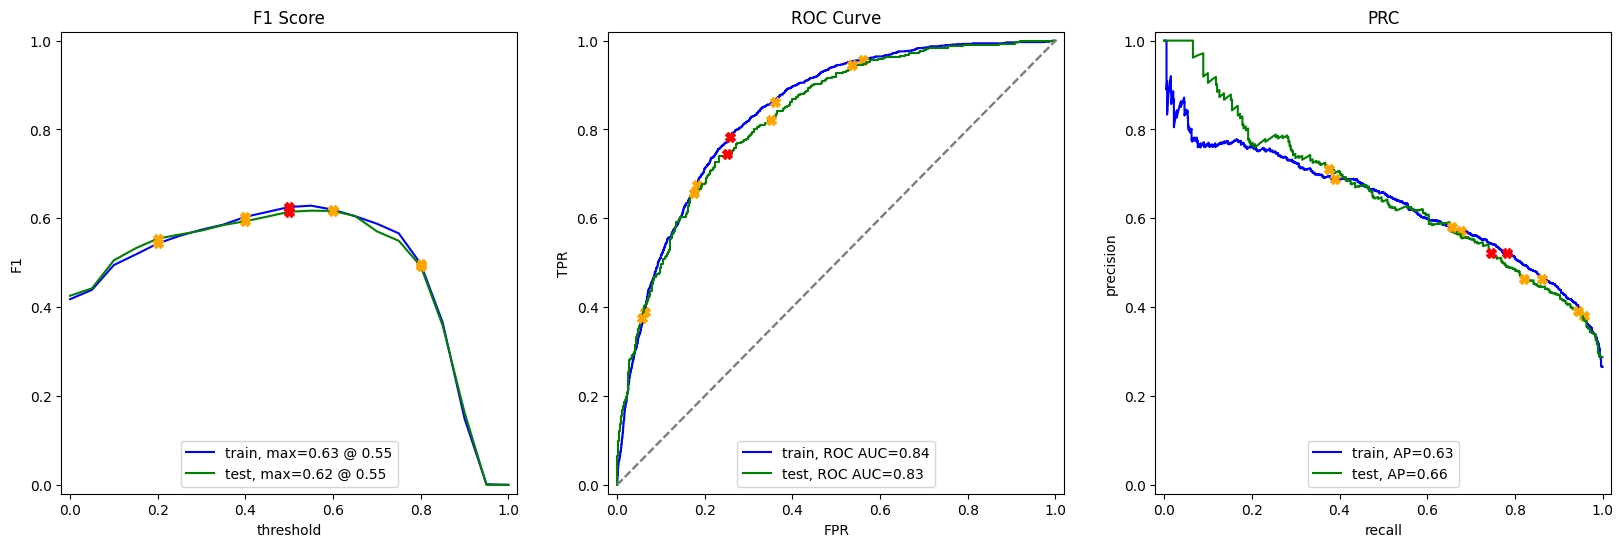

In [12]:
model = LogisticRegression(random_state=54321, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
print("Logistic Regression with Class Balance")
evaluate_model(model, features_train, target_train, features_test, target_test)

Logistic Regression with Upsampling
          train  test
Accuracy   0.59  0.60
F1         0.55  0.56
APS        0.62  0.65
ROC AUC    0.84  0.83


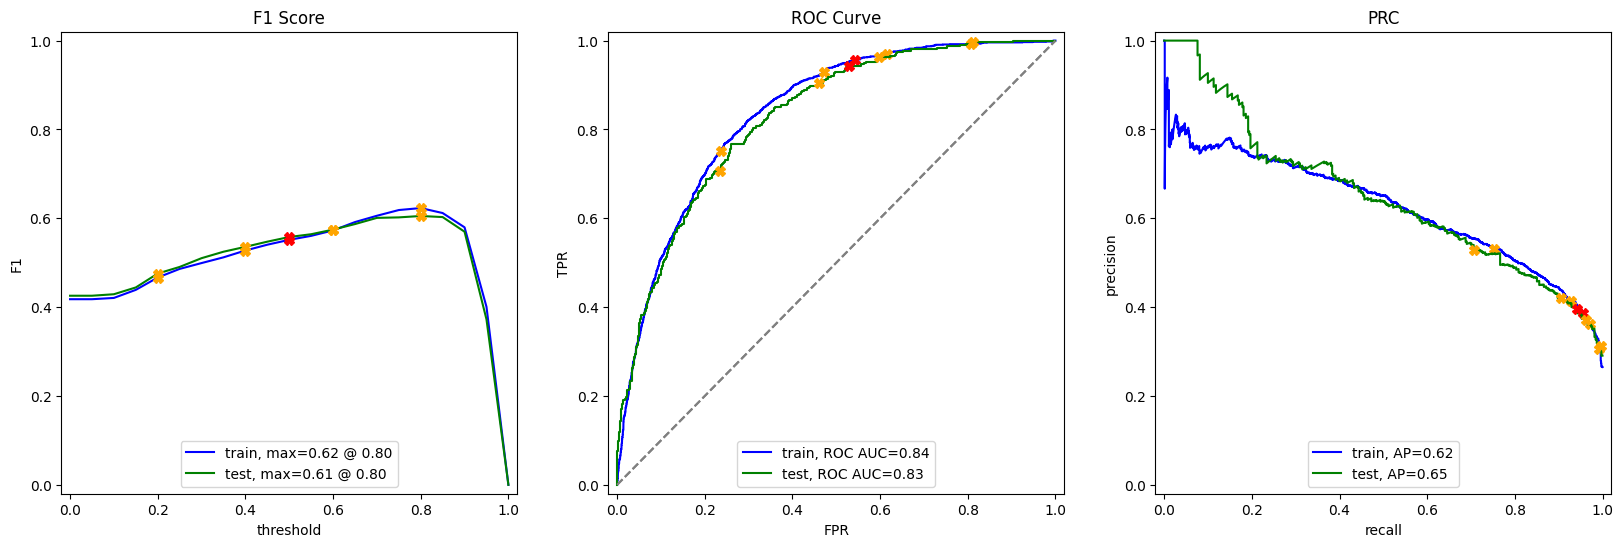

In [13]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=54321)

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)
model = LogisticRegression(random_state=54321, solver='liblinear')
model.fit(features_upsampled, target_upsampled)

print('Logistic Regression with Upsampling')
evaluate_model(model, features_train, target_train, features_test, target_test)

Logistic Regression with Downsampling
          train  test
Accuracy   0.59  0.60
F1         0.55  0.56
APS        0.61  0.63
ROC AUC    0.83  0.82


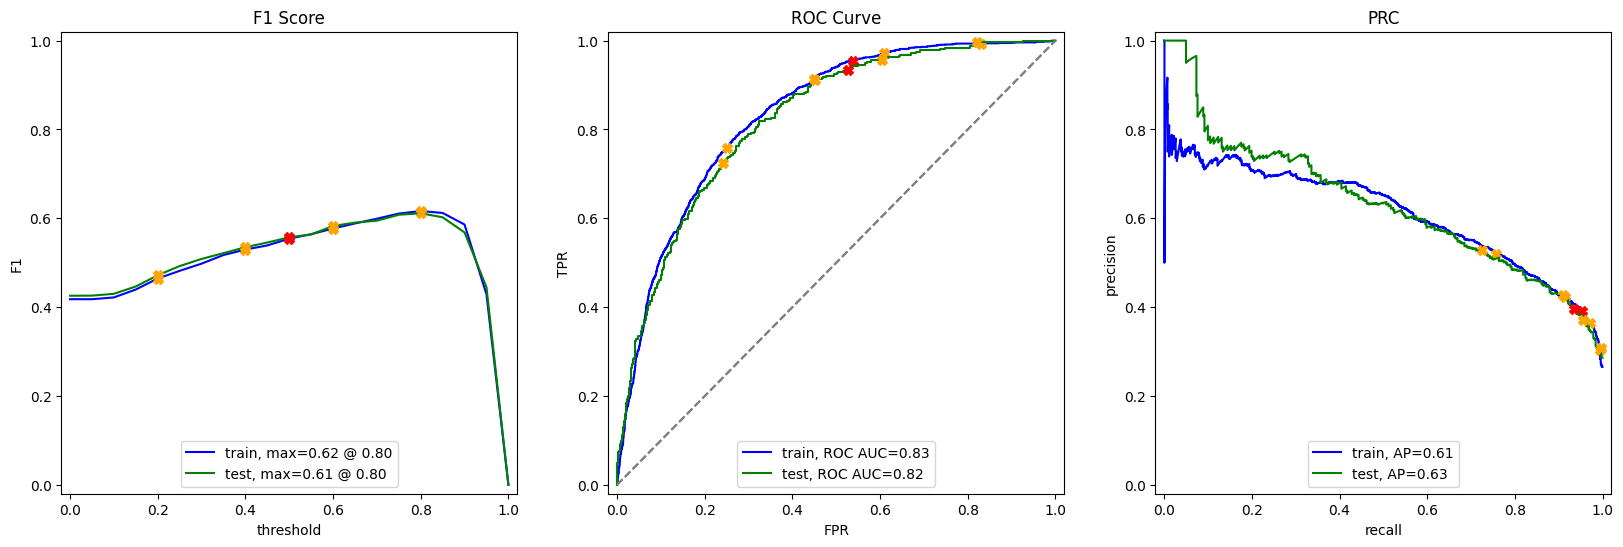

In [14]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=54321)]+ [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=54321)]+ [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=54321)

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)
model = LogisticRegression(random_state=54321, solver='liblinear')
model.fit(features_downsampled, target_downsampled)

print('Logistic Regression with Downsampling')
evaluate_model(model, features_train, target_train, features_test, target_test)

Random Forest with Class Balance
          train  test
Accuracy   0.86  0.78
F1         0.78  0.63
APS        0.82  0.67
ROC AUC    0.94  0.84


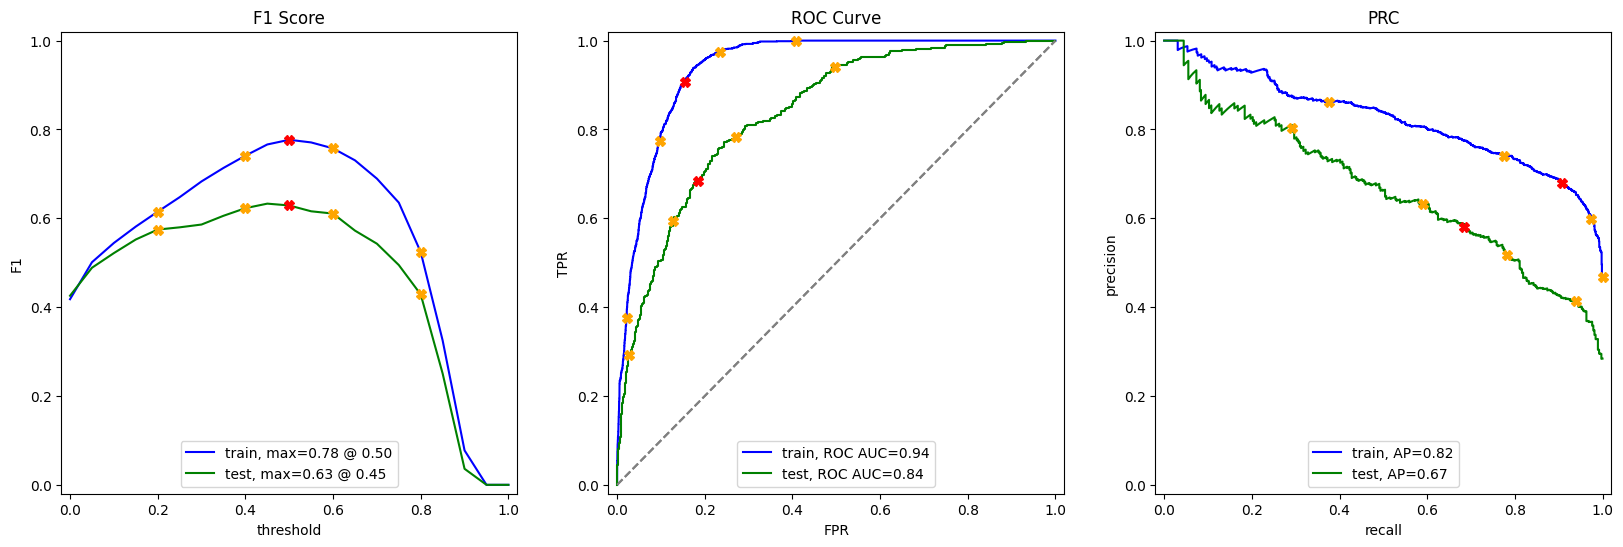

In [15]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(10, 100, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, 
                                       random_state=54321, class_weight='balanced')
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_test)
        result = mean_squared_error(target_test, predictions_valid)**0.5
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

model = RandomForestClassifier(random_state=54321, max_depth=best_depth, 
                               n_estimators=best_est, class_weight='balanced')
model.fit(features_train, target_train)
print("Random Forest with Class Balance")
evaluate_model(model, features_train, target_train, features_test, target_test)

Decision Tree with Class Balance
          train  test
Accuracy   0.76  0.74
F1         0.64  0.61
APS        0.66  0.66
ROC AUC    0.85  0.83


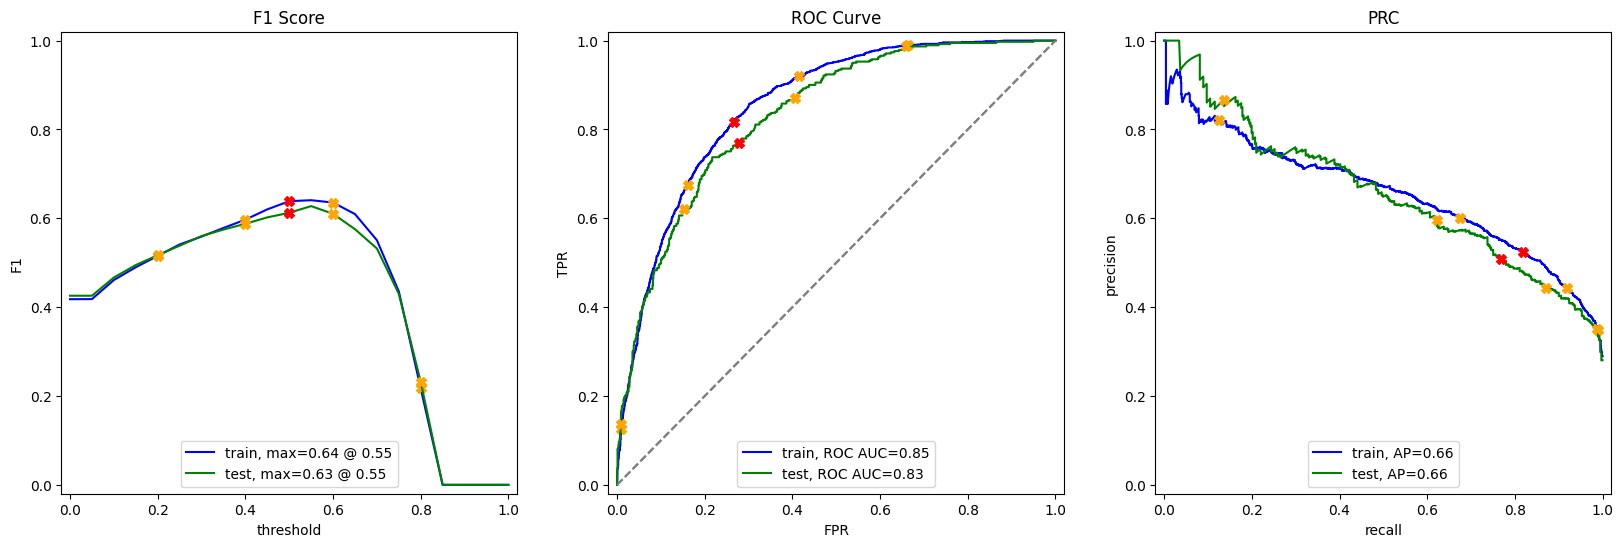

In [16]:
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(max_depth=depth, random_state=54321, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_test)
    result = mean_squared_error(target_test, predictions_valid)**0.5
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth

model = RandomForestClassifier(random_state=54321, max_depth=best_depth, class_weight='balanced')
model.fit(features_train, target_train)
print("Decision Tree with Class Balance")
evaluate_model(model, features_train, target_train, features_test, target_test)

LightGBM with Class Balance
          train  test
Accuracy   0.86  0.76
F1         0.78  0.62
APS        0.83  0.68
ROC AUC    0.94  0.84


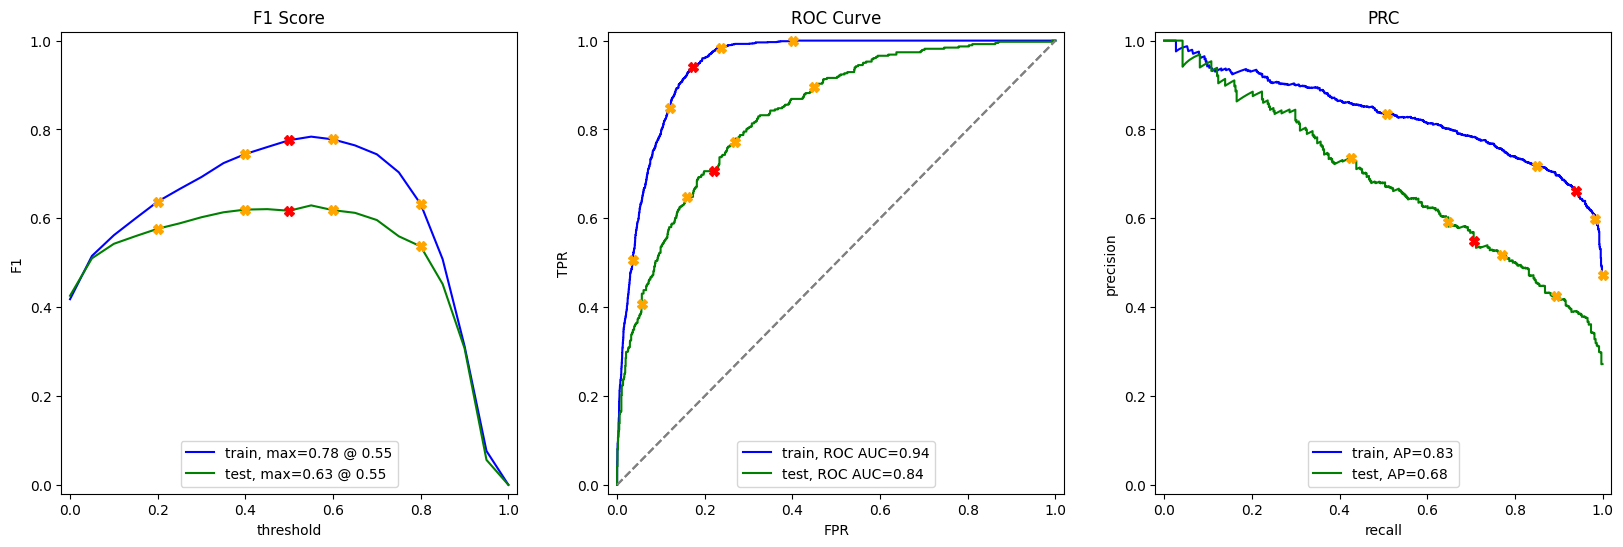

In [17]:
model = LGBMClassifier(random_state=54321, class_weight='balanced')
model.fit(features_train, target_train)
print("LightGBM with Class Balance")
evaluate_model(model, features_train, target_train, features_test, target_test)

In my model section, I noticed that my dataset was imbalanced, with significantly more customers who stayed (5,174) than those who left (1,869). This imbalance could cause my models to predict that most customers will stay, which wouldn't be helpful for identifying at-risk customers. To address this, I implemented the class balancing technique to ensure my models would properly learn to recognize both types of customers. I tested several different approaches, including logistic regression with built-in class balancing, upsampling (creating more examples of churning customers), and downsampling (reducing examples of staying customers). My logistic regression models with class balancing achieved around 75% accuracy, while the sampling techniques reached about 60% accuracy. I also tested a decision tree model, which performed similarly to the balanced logistic regression at 74% accuracy. However, my most sophisticated models, Random Forest and LightGBM, showned the best results, achieving 78% and 76% accuracy. These models also demonstrated predictive reliability with ROC AUC scores of 0.84, meaning they can effectively distinguish between customers who will stay and those who will leave. While these models showed some overfitting on training data, they still provided the most dependable predictions for identifying at-risk customers, making them ideal for helping the business proactively retain valuable customers.
